In [ ]:
import netCDF4 as nc
import numpy as np

with nc.Dataset('/Users/XXXXX/WDomains/SOceans2/wrfout_d02_2024-09-01_06:00:00') as f:
    xlong=f.variables['XLONG'][:]
    xlat=f.variables['XLAT'][:]
    rainc=f.variables['RAINC'][:]
    rainnc=f.variables['RAINNC'][:]
    qr=f.variables['QRAIN'][:]
    qg=f.variables['QGRAUP'][:]
    qs=f.variables['QSNOW'][:]
    qc=f.variables['QCLOUD'][:]
    qv=f.variables['QVAPOR'][:]
    qnrain=f.variables['QNRAIN'][:]
    qng=f.variables['QNGRAUPEL'][:]
    qns=f.variables['QNSNOW'][:]
    qtot=qr+qg+qs
    gpt=f.variables['PHB'][:]+f.variables['PH'][:]
    dgp=gpt[:,1:,:,:]-gpt[:,:-1,:,:]
    p=f.variables['P'][:,:,:,:]+f.variables['PB'][:,:,:,:]
    theta=(f.variables['T'][:,:,:,:]+300.)
    t=theta*(p/100000.)**0.286
    u10=f.variables['U10'][:]
    v10=f.variables['V10'][:]
    wspd=np.sqrt(u10**2+v10**2)
    #print(fh.variables['QIR'])
    rho=p/(287.*t)
    print(f.variables.keys())

dict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'BATHYMETRY_FLAG', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'AREA2D', 'DX2D', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'QNICE', 'QNSNOW', 'QNRAIN', 'QNGRAUPEL', 'SHDMAX', 'SHDMIN', 'SHDAVG', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'WATER_DEPTH', 'COSZEN', 'LAI', 'VAR', 'O3_GFS_DU', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY', 'F', 'E', 'SI

In [ ]:
qrain=qr
height=gpt
qice=qg+qs
ncice=qng+qns
ncrain=qnrain
import gcloud
import lkTables
import rtlib as libSc
import numpy as np
lkTables=lkTables.scattTables() 
from bisectm import bisectm
it=0
a=np.nonzero(qrain[it,0,:,:]>-1e-5)
print(a[0].shape)
#stop
rhoice=100.0
nz=qrain.shape[1]
nz80=80
qice_1d=np.zeros((nz80),float)
dmice_1d=np.zeros((nz80),float)
qrain_1d=np.zeros((nz80),float)
ncice_1d=np.zeros((nz80),float)
zKuSim=np.zeros((nz80),float)
zKaSim=np.zeros((nz80),float)
zKu_true=np.zeros((nz80),float)
zKa_true=np.zeros((nz80),float)
nt,nz,ny,nx=qrain.shape
piaKu2D=np.zeros((ny,nx),float)
piaKa2D=np.zeros((ny,nx),float)
nfreqm=8

kext3D=np.zeros((nz80,ny,nx,nfreqm),float)
salb3D=np.zeros((nz80,ny,nx,nfreqm),float)
asym3D=np.zeros((nz80,ny,nx,nfreqm),float)
t3D=np.zeros((nz80+1,ny,nx),float)
btemp2d=np.zeros((ny,nx),float)
it=1
tbout2d=np.zeros((ny,nx,nfreqm),float)
freq_set=[10.6,18.7,23.,37.,89,166,186,190]
rwp=np.zeros((ny,nx),float)
iwp=np.zeros((ny,nx),float)
cldwp=np.zeros((ny,nx),float)
tpw=np.zeros((ny,nx),float)

for i,j in zip(a[0],a[1]):
    qice_1dtmp=qice[it,:,i,j].copy()
    qrain_1dtmp=qrain[it,:,i,j].copy()
    dmice_1dtmp=qice[it,:,i,j].copy()*0
    dmrain_1dtmp=qrain[it,:,i,j].copy()*0
    hm=(height[it,1:,i,j]+height[it,:-1,i,j])/2/9.81e3
    hgrid=height[it,0,i,j]/9.81e3+np.arange(nz80)*0.25+0.125
    rwc_1d=np.interp(hgrid,hm,qrain[it,:,i,j]*rho[it,:,i,j]*1e3)
    iwc_1d=np.interp(hgrid,hm,qice[it,:,i,j]*rho[it,:,i,j]*1e3)
    cldw_1d=np.interp(hgrid,hm,qc[it,:,i,j]*rho[it,:,i,j]*1e3)
    qv_1d=np.interp(hgrid,hm,qv[it,:,i,j])
    
    for k1 in range(nz-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        if(qice[it,k1,i,j]>1e-5):
            dmice=4/(ncice[it,k1,i,j]*3.1415*rhoice/qice[it,k1,i,j])**0.333*1e3
            dmice_1dtmp[k1]=dmice
        if(qrain[it,k1,i,j]>1e-5):
            dmrain=4/(ncrain[it,k1,i,j]*3.1415*1000/qrain[it,k1,i,j])**0.333*1e3
            dmrain_1dtmp[k1]=dmrain
    cldwp[i,j]=np.sum(cldw_1d)
    iwp[i,j]=np.sum(iwc_1d)
    rwp[i,j]=np.sum(rwc_1d)
    tpw[i,j]=np.sum(qv[it,:,i,j]*dgp[it,:,i,j])
    dmice_1d=np.interp(hgrid,hm,dmice_1dtmp)
    dmrain_1d=np.interp(hgrid,hm,dmrain_1dtmp)
    nfreqm=8
    kext1D=np.zeros((nz80,nfreqm),float)
    salb1D=np.zeros((nz80,nfreqm),float)
    asym1D=np.zeros((nz80,nfreqm),float)
    kextAtmAllFreq=[]
    for freq in [10.6,18.7,23.,37.,89,166,186,190]:
        kextatm=[]
        for k1 in range(nz):
            ireturn=0
            absair,abswv = libSc.gasabsr98(freq,t[it,k1,i,j],qv[it,k1,i,j]*rho[it,k1,i,j],p[it,k1,i,j],ireturn)
            z_cloud=gcloud.gcloud(freq,t[it,k1,i,j],cldw_1d[k1])
            kextatm.append(absair+abswv+z_cloud)
        kextAtmAllFreq.append(kextatm)
    kextAtmAllFreq=np.array(kextAtmAllFreq).T
        
    piaKu=0
    piaKa=0
    dr=0.25
    for k1 in range(nz80-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dmice_1d[k1]=max(lkTables.dms[0],dmice_1d[k1])
        dmice_1d[k1]=min(dmice_1d[k1],lkTables.dms[-1])
        dmrain_1d[k1]=max(lkTables.dmr[0],dmrain_1d[k1])
        dmrain_1d[k1]=min(dmrain_1d[k1],lkTables.dmr[-1])
        if iwc_1d[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
            ind=bisectm(lkTables.dms.data,253,dmice_1d[k1])
            dn_ice=np.log10(iwc_1d[k1]/lkTables.gwc.data[ind])
            zKu_ice=lkTables.zKuS[ind]+10*dn_ice
            zKa_ice=lkTables.zKaS[ind]+10*dn_ice
            attKu_ice=lkTables.attKuS[ind]*10**dn_ice
            attKa_ice=lkTables.attKaS[ind]*10**dn_ice
            attKu+=attKu_ice
            attKa+=attKa_ice
            zku+=10**(0.1*zKu_ice)
            zka+=10**(0.1*zKa_ice)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dn_ice*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        
        if rwc_1d[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmrain_1d[k1])
            dnr=np.log10(rwc_1d[k1]/lkTables.rwc.data[ind])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    piaKu2D[i,j]=piaKu
    piaKa2D[i,j]=piaKa
    umu=np.cos(53/180*3.1415)
    btemp=t[it,0,i,j]
    nz81=nz80+1
    hgrid1=height[it,0,i,j]/9.81e3+np.arange(nz81)*0.25
    lyrtemp=np.interp(hgrid1,hm,t[it,:,i,j])
    lyrhgt=hgrid1
    tboutL=[]


    for ifreq in range(nfreqm):
        kext=kext1D[:,ifreq]+np.interp(hgrid,hm,kextAtmAllFreq[:,ifreq])
        salb=salb1D[:,ifreq]
        asym=asym1D[:,ifreq]
        asalb=np.nonzero(salb>1e-3)
        asym[asalb]=asym[asalb]/salb[asalb]
        salb/=kext
        fisot=2.7
        emis=0.6
        ebar=0.6
        npol=0
        freq=freq_set[ifreq]
        emis,ebar=libSc.emit(freq,npol,btemp,wspd[it,i,j],umu)
        tbout = libSc.radtran(umu,btemp,lyrtemp,lyrhgt,kext,salb,asym,fisot,emis,ebar)
        #rtlib.radtran(umu,skTemp[i,j],temp1d1,height,kext1d,salb1d,asym1d,fisot,sfcEmiss[i,j,ic],sfcEmiss[i,j,ic])
        tbout2d[i,j,ifreq]=tbout
        tboutL.append(tbout)
        kext3D[:,i,j,ifreq]=kext
        salb3D[:,i,j,ifreq]=salb
        asym3D[:,i,j,ifreq]=asym
        t3D[:,i,j]=lyrtemp
        btemp2d[i,j]=btemp


(32913,)


In [58]:
import xarray as xr
cldwp_xr=xr.DataArray(cldwp,dims=['y','x'])
iwp_xr=xr.DataArray(iwp,dims=['y','x'])
rwp_xr=xr.DataArray(rwp,dims=['y','x'])
tpw_xr=xr.DataArray(tpw,dims=['y','x'])
piaKu2D_xr=xr.DataArray(piaKu2D,dims=['y','x'])
piaKa2D_xr=xr.DataArray(piaKa2D,dims=['y','x'])
tbout2d_xr=xr.DataArray(tbout2d,dims=['y','x','f'])
xlon_xr=xr.DataArray(xlong[0,:,:],dims=['y','x'])
xlat_xr=xr.DataArray(xlat[0,:,:],dims=['y','x'])
ds=xr.Dataset({'cldwp':cldwp_xr,'iwp':iwp_xr,'rwp':rwp_xr,'tpw':tpw_xr,'piaKu':piaKu2D_xr,'piaKa':piaKa2D_xr,'tbout':tbout2d_xr,'xlon':xlon_xr,'xlat':xlat_xr})
compLev=6
encoding = {var: {'zlib': True, 'complevel': compLev} for var in ds.data_vars}
ds.to_netcdf('simulated_tb_wrf_09-01_08:30:00_with_clouds.nc',encoding=encoding)

/Users/XXXXX/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/Users/XXXXX/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


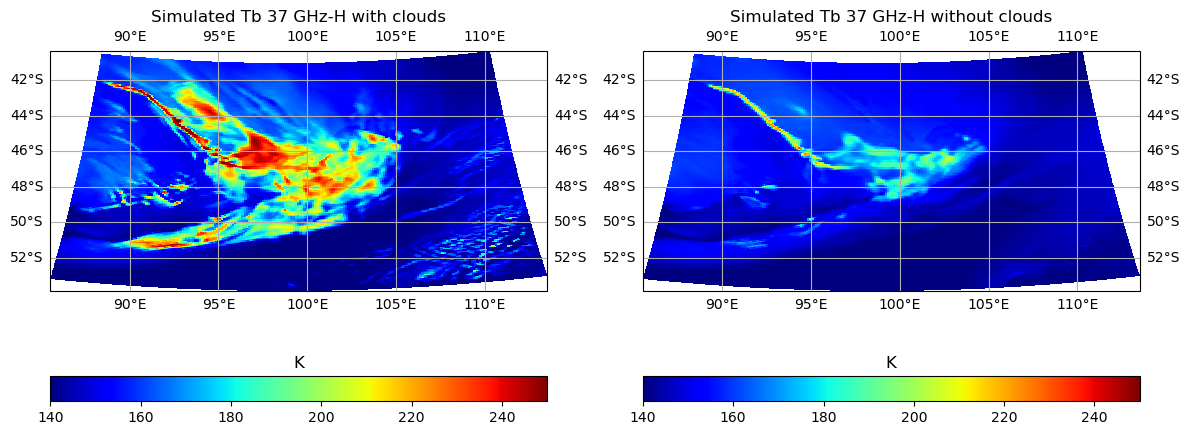

In [70]:
with nc.Dataset('simulated_tb_wrf_09-01_07:00:00_with_clouds.nc') as f:
    tbout2d_clouds=f.variables['tbout'][:]

with nc.Dataset('simulated_tb_wrf_09-01_07:00:00_without_clouds.nc') as f:
    tbout2d=f.variables['tbout'][:]
    
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
ax1=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
plt.pcolormesh(xlong[0,:,:],xlat[0,:,:],tbout2d_clouds[:,:,3],cmap='jet', transform=ccrs.PlateCarree(),vmin=140,vmax=250)
ax1.coastlines()
gl1=ax1.gridlines(draw_labels=True)
gl1.right_label=False
cbar_=plt.colorbar(orientation='horizontal')
cbar_.ax.set_title('K')
plt.title('Simulated Tb 37 GHz-H with clouds')
ax2=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
plt.pcolormesh(xlong[0,:,:],xlat[0,:,:],tbout2d[:,:,3],cmap='jet',transform=ccrs.PlateCarree(),vmin=140,vmax=250)
ax2.coastlines()
gl2=ax2.gridlines(draw_labels=True)
gl2.left_label=False
cbar=plt.colorbar(orientation='horizontal')
cbar.ax.set_title('K')
plt.tight_layout()
plt.title('Simulated Tb 37 GHz-H without clouds')
plt.savefig('wrf_tb_89GHz_20240901_07:00.png',dpi=300)